In [8]:
import numpy as np
import pandas as pd
import json
from datetime import datetime, timedelta
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, deque
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score


In [9]:
class CourseLoader:
    def __init__(self, json_file_path):
        """Khởi tạo CourseLoader với đường dẫn tới file JSON."""
        self.json_file_path = json_file_path
        self.course_data = self._load_course_data()
        self.learning_objects = self._extract_learning_objects()

    def _load_course_data(self):
        """Đọc dữ liệu khóa học từ file JSON."""
        try:
            with open(self.json_file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
            return data['course']
        except FileNotFoundError:
            print(f"File {self.json_file_path} không tồn tại")
            return None
        except json.JSONDecodeError:
            print(f"File {self.json_file_path} không đúng định dạng JSON")
            return None

    def _extract_learning_objects(self):
        """Trích xuất danh sách learning objects từ dữ liệu khóa học."""
        if not self.course_data:
            return {}

        learning_objects = {}
        chapters = self.course_data.get('chapters', {})

        for chapter_key, chapter in chapters.items():
            learning_units = chapter.get('learning_units', {})
            for unit_key, unit in learning_units.items():
                learning_objects_data = unit.get('learning_objects', {})
                for obj_id, obj_info in learning_objects_data.items():
                    learning_objects[obj_id] = {
                        'dok_level': obj_info['dok_level'],
                        'activity_type': obj_info['activity_type'],
                        'duration': obj_info['duration'],
                        'has_assessment': obj_info['has_assessment'],
                        'prerequisites': obj_info['prerequisites'],
                        'optional_paths': obj_info['optional_paths']
                    }
        return learning_objects

    def get_learning_objects(self):
        """Trả về danh sách learning objects."""
        return self.learning_objects

    def get_course_info(self):
        """Trả về thông tin tổng quan về khóa học."""
        if not self.course_data:
            return None
        return {
            'title': self.course_data.get('title', ''),
            'description': self.course_data.get('description', ''),
            'language': self.course_data.get('language', ''),
            'total_duration': self.course_data.get('total_duration', 0)
        }

    def get_chapter_info(self, chapter_id):
        """Trả về thông tin về một chapter cụ thể."""
        if not self.course_data:
            return None
        return self.course_data.get('chapters', {}).get(chapter_id, None)

    def get_learning_unit_info(self, chapter_id, unit_id):
        """Trả về thông tin về một learning unit cụ thể."""
        if not self.course_data:
            return None
        chapter = self.course_data.get('chapters', {}).get(chapter_id, {})
        return chapter.get('learning_units', {}).get(unit_id, None)

In [10]:
class MoodleLogGenerator:
    def __init__(self, course_loader):
        """Khởi tạo MoodleLogGenerator với CourseLoader."""
        self.course_loader = course_loader
        self.learning_objects = course_loader.get_learning_objects()
        self.course_info = course_loader.get_course_info()

    def generate_user_logs(self, num_users=100, days_range=30, seed=None):
        """Sinh log tương tác của user với khóa học."""
        if seed is not None:
            random.seed(seed)
        
        logs = []
        for user_id in range(1, num_users + 1):
            # Tạo profile user với khả năng học tập và mức độ tương tác
            user_ability = random.uniform(0.3, 1.0)
            user_engagement = random.uniform(0.4, 1.0)
            
            # Sinh log cho mỗi user
            user_logs = self._generate_user_session(user_id, user_ability, user_engagement, days_range)
            logs.extend(user_logs)
        
        # Chuyển logs thành DataFrame
        logs_df = pd.DataFrame(logs)
        return logs_df

    def _generate_user_session(self, user_id, ability, engagement, days_range):
        """Sinh log session cho một user."""
        logs = []
        start_date = datetime.now() - timedelta(days=days_range)
        
        # Tạo sequence học tập theo thứ tự logic, có tính đến prerequisites
        learning_sequence = self._build_learning_sequence()
        current_position = 0
        
        # Số session học tập của user, phụ thuộc vào mức độ tương tác
        num_sessions = int(random.uniform(5, 25) * engagement)
        
        for session in range(num_sessions):
            # Tạo thời gian ngẫu nhiên cho session trong khoảng days_range
            session_date = start_date + timedelta(days=random.randint(0, days_range), hours=random.randint(0, 23), minutes=random.randint(0, 59))
            
            # Chọn learning object để học
            if current_position < len(learning_sequence):
                current_obj = learning_sequence[current_position]
                if current_obj not in self.learning_objects:
                    continue  # Bỏ qua nếu object_id không hợp lệ
                
                obj_info = self.learning_objects[current_obj]
                
                # Kiểm tra prerequisites
                if not self._check_prerequisites(current_obj, logs, user_id):
                    continue  # Bỏ qua nếu chưa hoàn thành prerequisites
                
                # Sinh log tương tác
                log_entry = self._create_log_entry(
                    user_id, session_date, current_obj, obj_info, ability, engagement
                )
                logs.append(log_entry)
                
                # Quyết định có tiến tới object tiếp theo không
                success_prob = min(0.9, ability + 0.1 * (4 - obj_info['dok_level']))
                if random.random() < success_prob and (log_entry['score'] is None or log_entry['score'] >= 60):
                    current_position += 1
                    # Xem xét optional paths
                    if obj_info['optional_paths']:
                        if random.random() < 0.3:  # 30% khả năng chọn optional path
                            next_obj = random.choice(obj_info['optional_paths'])
                            if next_obj in learning_sequence:
                                current_position = learning_sequence.index(next_obj)
        
        return logs

    def _build_learning_sequence(self):
        """Xây dựng sequence học tập dựa trên prerequisites và optional paths."""
        sequence = []
        visited = set()
        
        def add_object(obj_id):
            if obj_id in visited or obj_id not in self.learning_objects:
                return
            obj_info = self.learning_objects[obj_id]
            # Thêm prerequisites trước
            for prereq in obj_info['prerequisites']:
                add_object(prereq)
            # Thêm object hiện tại
            if obj_id not in visited:
                sequence.append(obj_id)
                visited.add(obj_id)
            # Thêm optional paths (không bắt buộc)
            for opt_path in obj_info['optional_paths']:
                if random.random() < 0.5:  # 50% khả năng thêm optional path
                    add_object(opt_path)
        
        # Bắt đầu từ các learning object không có prerequisites
        for obj_id, obj_info in self.learning_objects.items():
            if not obj_info['prerequisites']:
                add_object(obj_id)
        
        # Thêm các object còn lại nếu chưa được thăm
        for obj_id in self.learning_objects:
            add_object(obj_id)
        
        return sequence

    def _check_prerequisites(self, obj_id, logs, user_id):
        """Kiểm tra xem user đã hoàn thành các prerequisites của learning object chưa."""
        if obj_id not in self.learning_objects:
            return False
        prerequisites = self.learning_objects[obj_id]['prerequisites']
        if not prerequisites:
            return True
        
        user_logs = [log for log in logs if log['user_id'] == user_id]
        completed_objects = {log['object_id'] for log in user_logs if log['completed']}
        
        return all(prereq in completed_objects for prereq in prerequisites)

    def _create_log_entry(self, user_id, timestamp, object_id, obj_info, ability, engagement):
        """Tạo một log entry."""
        # Tính toán thời gian học
        base_time = obj_info['duration']
        time_spent = int(base_time * random.uniform(0.5, 2.0) / ability)
        
        # Tính điểm số nếu có assessment
        score = None
        attempts = 0
        
        if obj_info['has_assessment']:
            attempts = random.randint(1, 3)
            # Điểm số phụ thuộc vào ability, engagement và DOK level
            base_score = (ability * 0.7 + engagement * 0.3) * 100
            difficulty_penalty = (obj_info['dok_level'] - 1) * 10
            score = max(0, min(100, base_score - difficulty_penalty + random.uniform(-15, 15)))
        
        return {
            'user_id': user_id,
            'timestamp': timestamp,
            'object_id': object_id,
            'chapter': '.'.join(object_id.split('.')[:1]),  # Lấy chapter (e.g., "1" từ "1.1.1")
            'unit': '.'.join(object_id.split('.')[:2]),     # Lấy unit (e.g., "1.1" từ "1.1.1")
            'dok_level': obj_info['dok_level'],
            'activity_type': obj_info['activity_type'],
            'time_spent': time_spent,
            'score': score,
            'attempts': attempts,
            'has_assessment': obj_info['has_assessment'],
            'completed': score is None or score >= 60
        }

    def save_logs_to_csv(self, logs_df, filename='moodle_logs.csv'):
        """Lưu logs vào file CSV."""
        logs_df.to_csv(filename, index=False, encoding='utf-8')
        print(f"Đã lưu {len(logs_df)} log entries vào {filename}")

    def load_logs_from_csv(self, filename='moodle_logs.csv'):
        """Đọc logs từ file CSV."""
        if os.path.exists(filename):
            df = pd.read_csv(filename, encoding='utf-8')
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            print(f"Đã đọc {len(df)} log entries từ {filename}")
            return df
        else:
            print(f"File {filename} không tồn tại")
            return None



In [11]:
class UserClusteringService:
    def __init__(self, n_clusters=3):
        self.n_clusters = n_clusters
        self.scaler = StandardScaler()
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.variance_selector = VarianceThreshold(threshold=0.1)
        
    def find_optimal_clusters(self, user_features_df, k_range=range(2, 11)):
            """Tìm số cụm tối ưu bằng silhouette score"""
            feature_cols = user_features_df.columns.drop('user_id')
            X = user_features_df[feature_cols].fillna(0)
            X_selected = self.variance_selector.fit_transform(X)
            X_scaled = self.scaler.fit_transform(X_selected)

            best_score = -1
            best_k = 2

            for k in k_range:
                kmeans = KMeans(n_clusters=k, random_state=42)
                labels = kmeans.fit_predict(X_scaled)
                score = silhouette_score(X_scaled, labels)

                print(f"Số cụm: {k}, Silhouette Score = {score:.4f}")
                if score > best_score:
                    best_score = score
                    best_k = k

            print(f"✅ Số cụm tối ưu là: {best_k} (Silhouette Score = {best_score:.4f})")
            self.kmeans = KMeans(n_clusters=best_k, random_state=42)  # cập nhật model
            return best_k
        
    def prepare_features(self, logs_df):
        """Chuẩn bị features cho clustering"""
        # Tính toán features cho mỗi user
        user_features = []
        
        for user_id in logs_df['user_id'].unique():
            user_logs = logs_df[logs_df['user_id'] == user_id]
            
            features = {
                'user_id': user_id,
                'total_time': user_logs['time_spent'].sum(),
                'avg_score': user_logs['score'].dropna().mean() if len(user_logs['score'].dropna()) > 0 else 0,
                'completion_rate': user_logs['completed'].mean(),
                'avg_attempts': user_logs['attempts'].mean(),
                'dok_1_time': user_logs[user_logs['dok_level'] == 1]['time_spent'].sum(),
                'dok_2_time': user_logs[user_logs['dok_level'] == 2]['time_spent'].sum(),
                'dok_3_time': user_logs[user_logs['dok_level'] == 3]['time_spent'].sum(),
                'dok_4_time': user_logs[user_logs['dok_level'] == 4]['time_spent'].sum(),
                'sessions_count': len(user_logs),
                'avg_session_length': user_logs['time_spent'].mean(),
                'video_time': user_logs[user_logs['activity_type'] == 'video']['time_spent'].sum(),
                'practice_time': user_logs[user_logs['activity_type'] == 'practice']['time_spent'].sum(),
                'quiz_time': user_logs[user_logs['activity_type'] == 'quiz']['time_spent'].sum(),
                'project_time': user_logs[user_logs['activity_type'] == 'project']['time_spent'].sum()
            }
            
            user_features.append(features)
        
        return pd.DataFrame(user_features)
    
    def cluster_users(self, user_features_df):
        """Phân cụm users dựa trên features có phương sai cao"""
        # Loại bỏ cột user_id để clustering
        feature_cols = user_features_df.columns.drop('user_id')
        X = user_features_df[feature_cols].fillna(0)
        
        # Chọn features có phương sai cao
        X_selected = self.variance_selector.fit_transform(X)
        
        # Chuẩn hóa dữ liệu
        X_scaled = self.scaler.fit_transform(X_selected)
        
        # Phân cụm
        clusters = self.kmeans.fit_predict(X_scaled)
        
        # Thêm cluster labels vào DataFrame
        user_features_df['cluster'] = clusters
        
        return user_features_df
    
    def get_cluster_characteristics(self, user_features_df):
        """Phân tích đặc điểm của từng cluster"""
        cluster_stats = user_features_df.groupby('cluster').agg({
            'total_time': ['mean', 'std'],
            'avg_score': ['mean', 'std'],
            'completion_rate': ['mean', 'std'],
            'avg_attempts': ['mean', 'std'],
            'sessions_count': ['mean', 'std']
        }).round(2)
        
        return cluster_stats
    
    def visualize_clusters(self, user_features_df):
        """Vẽ biểu đồ trực quan các cluster"""
        plt.figure(figsize=(15, 10))
        
        # Subplot 1: Scatter plot của total_time vs avg_score
        plt.subplot(2, 3, 1)
        scatter = plt.scatter(user_features_df['total_time'], 
                            user_features_df['avg_score'], 
                            c=user_features_df['cluster'], 
                            cmap='viridis', alpha=0.6)
        plt.xlabel('Tổng thời gian học (phút)')
        plt.ylabel('Điểm trung bình')
        plt.title('Phân bố Cluster: Thời gian vs Điểm số')
        plt.colorbar(scatter)
        
        # Subplot 2: Box plot của completion_rate theo cluster
        plt.subplot(2, 3, 2)
        user_features_df.boxplot(column='completion_rate', by='cluster', ax=plt.gca())
        plt.title('Tỷ lệ hoàn thành theo Cluster')
        plt.suptitle('')
        
        # Subplot 3: Bar chart của avg_attempts theo cluster
        plt.subplot(2, 3, 3)
        cluster_attempts = user_features_df.groupby('cluster')['avg_attempts'].mean()
        cluster_attempts.plot(kind='bar', color=['red', 'green', 'blue'])
        plt.title('Số lần thử trung bình theo Cluster')
        plt.ylabel('Số lần thử')
        plt.xlabel('Cluster')
        
        # Subplot 4: Stacked bar chart của thời gian theo DOK level
        plt.subplot(2, 3, 4)
        dok_cols = ['dok_1_time', 'dok_2_time', 'dok_3_time', 'dok_4_time']
        dok_data = user_features_df.groupby('cluster')[dok_cols].mean()
        dok_data.plot(kind='bar', stacked=True, ax=plt.gca())
        plt.title('Thời gian học theo DOK Level')
        plt.ylabel('Thời gian (phút)')
        plt.xlabel('Cluster')
        plt.legend(title='DOK Level')
        
        # Subplot 5: Pie chart cho distribution của clusters
        plt.subplot(2, 3, 5)
        cluster_counts = user_features_df['cluster'].value_counts()
        plt.pie(cluster_counts.values, labels=[f'Cluster {i}' for i in cluster_counts.index], autopct='%1.1f%%')
        plt.title('Phân bố số lượng User theo Cluster')
        
        # Subplot 6: Heatmap correlation
        plt.subplot(2, 3, 6)
        correlation_cols = ['total_time', 'avg_score', 'completion_rate', 'avg_attempts', 'sessions_count']
        corr_matrix = user_features_df[correlation_cols].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Ma trận tương quan Features')
        
        plt.tight_layout()
        plt.savefig('cluster_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def save_clusters_to_csv(self, user_features_df, filename='user_clusters.csv'):
        """Lưu kết quả phân cụm vào CSV"""
        user_features_df.to_csv(filename, index=False, encoding='utf-8')
        print(f"Đã lưu thông tin {len(user_features_df)} users vào {filename}")


In [12]:

class QLearningRecommendationSystem:
    def __init__(self, course_loader, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        self.course_loader = course_loader
        self.learning_objects = course_loader.get_learning_objects()
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.actions = ['Stay', 'Next', 'Previous', 'Go_to_high_level', 'Go_to_low_level']
        self.q_table = {}

    def _get_q_value(self, state, action):
        if state not in self.q_table:
            self.q_table[state] = {}
        return self.q_table[state].get(action, 0.0)

    def _set_q_value(self, state, action, value):
        if state not in self.q_table:
            self.q_table[state] = {}
        self.q_table[state][action] = value

    def _get_object_position(self, object_id):
        try:
            return list(self.learning_objects.keys()).index(object_id)
        except ValueError:
            return 0

    def _state_to_string(self, state):
        return f"{state['cluster']}_{state['dok_level']}_{state['has_assessment']}" \
               f"_{state['score_normalized']:.2f}_{state['attempts']}" \
               f"_{state['time_normalized']:.2f}_{state['object_position']}"

    def create_state(self, user_id, cluster, current_object, score, attempts, time_spent):
        obj_info = self.learning_objects.get(current_object, {})
        normalized_score = score / 100.0 if score is not None else 0.0
        normalized_time = min(time_spent / 60.0, 1.0)
        state = {
            'cluster': cluster,
            'dok_level': obj_info.get('dok_level', 1),
            'has_assessment': obj_info.get('has_assessment', False),
            'score_normalized': normalized_score,
            'attempts': min(attempts, 5),
            'time_normalized': normalized_time,
            'object_position': self._get_object_position(current_object)
        }
        return self._state_to_string(state)

    def choose_action(self, state):
        if random.random() < self.epsilon or state not in self.q_table or not self.q_table[state]:
            return random.choice(self.actions)
        return max(self.q_table[state], key=self.q_table[state].get)

    def update_q_table(self, state, action, reward, next_state):
        current_q = self._get_q_value(state, action)
        max_next_q = max(self.q_table.get(next_state, {}).values(), default=0.0)
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self._set_q_value(state, action, new_q)

    def get_reward(self, old_state, action, new_state, _):
        old = old_state.split('_')
        new = new_state.split('_')
        old_score, new_score = float(old[3]), float(new[3])
        old_dok, new_dok = int(old[1]), int(new[1])
        old_pos, new_pos = int(old[6]), int(new[6])
        reward = 0

        # 🎯 Cải thiện điểm số
        if new_score > old_score:
            reward += (new_score - old_score) * 10

        # ✅ Tiến tới bài tiếp theo theo đúng trình tự
        if action == 'Next' and new_pos == old_pos + 1:
            reward += 10  # tuyến tính rõ ràng

        # 🔁 Quay lại bài trước (có thể để ôn)
        if action == 'Previous' and new_pos == old_pos - 1:
            reward += 2

        # ⬆️ Nhảy lên bài khó hơn (DOK cao hơn)
        if action == 'Go_to_high_level' and new_dok > old_dok:
            reward += 1  # thưởng ít để tránh lạm dụng

        # ⬇️ Nhảy xuống bài dễ hơn
        if action == 'Go_to_low_level' and new_dok < old_dok:
            reward -= 1  # trừ điểm nhẹ

        # 🛑 Đi lùi hoặc không tiến bộ
        if new_pos <= old_pos and action in ['Previous', 'Go_to_low_level', 'Stay']:
            reward -= 4  # phạt mạnh

        # 😴 Ở lại và không tiến bộ
        if action == 'Stay' and new_score <= old_score:
            reward -= 2

        return reward

    def _is_unlocked(self, current_object, next_object, visited):
        """
        Kiểm tra xem next_object đã được mở khóa chưa, 
        tức là tất cả các prerequisite đã nằm trong visited.
        """
        if next_object not in self.learning_objects:
            return False  # Không tồn tại trong cấu trúc khóa học

        prerequisites = self.learning_objects[next_object].get('prerequisites', [])
        
        # Nếu không có prerequisite nào, thì mặc định là unlocked
        if not prerequisites:
            return True

        # Kiểm tra tất cả prerequisites đã học chưa
        return all(p in visited for p in prerequisites)

    def _get_next_object(self, current_object, action, visited):
        objects = list(self.learning_objects.keys())
        idx = self._get_object_position(current_object)
        dok = self.learning_objects[current_object].get('dok_level', 1)
        optional = self.learning_objects[current_object].get('optional_paths', [])

        # 1. Stay
        if action == 'Stay':
            return current_object

        # 2. Next – ưu tiên optional paths, sau đó là object tiếp theo
        if action == 'Next':
            for obj in optional:
                if obj not in visited and self._is_unlocked(current_object, obj, visited):
                    return obj
            if idx + 1 < len(objects):
                obj = objects[idx + 1]
                if obj not in visited and self._is_unlocked(current_object, obj, visited):
                    return obj

        # 3. Previous
        if action == 'Previous' and idx > 0:
            obj = objects[idx - 1]
            if self._is_unlocked(current_object, obj, visited):
                return obj

        # 4. Go_to_high_level
        if action == 'Go_to_high_level':
            for obj in objects[idx + 1:]:  # bỏ current
                if self.learning_objects[obj]['dok_level'] > dok and \
                obj not in visited and \
                self._is_unlocked(current_object, obj, visited):
                    return obj

        # 5. Go_to_low_level
        if action == 'Go_to_low_level':
            for obj in reversed(objects[:idx]):
                if self.learning_objects[obj]['dok_level'] < dok and \
                obj not in visited and \
                self._is_unlocked(current_object, obj, visited):
                    return obj

        # 6. ✅ Fallback: tìm object chưa học nào có thể học tiếp
        for obj_id in objects:
            if obj_id not in visited and self._is_unlocked(current_object, obj_id, visited):
                return obj_id

        # 7. ❌ Không còn object mới hợp lệ → kết thúc
        return None

    def recommend_learning_path(self, user_id, cluster, current_object, score, attempts, time_spent, path_length=5):
        visited = set()
        recs = []
        score = score or 60.0
        attempts = attempts or 1
        time_spent = time_spent or 10

        for step in range(path_length):
            state = self.create_state(user_id, cluster, current_object, score, attempts, time_spent)
            action = self.choose_action(state)
            next_obj = self._get_next_object(current_object, action, visited)

            # ✅ Nếu không còn object nào hợp lệ nữa
            if next_obj is None:
                print("✅ Đã hoàn thành hết các object học được.")
                break

            if next_obj in visited:
                continue

            info = self.learning_objects[next_obj]
            pred_score = self.predict_score(info['dok_level'], info['duration'], attempts)

            recs.append({
                'step': step + 1,
                'action': action,
                'object_id': next_obj,
                'object_name': info.get('name', next_obj),
                'dok_level': info['dok_level'],
                'estimated_time': info['duration'],
                'has_assessment': info['has_assessment'],
                'predicted_score': round(pred_score, 1)
            })

            visited.add(next_obj)
            current_object, score, time_spent = next_obj, pred_score, info['duration']
            if info['has_assessment']:
                attempts = min(attempts + 1, 5)

        return recs

    def train(self, logs_df, user_clusters_df, episodes=1000):
        print("Bắt đầu huấn luyện Q-learning...")
        logs = logs_df.merge(user_clusters_df[['user_id', 'cluster']], on='user_id')
        for ep in range(episodes):
            if ep % 100 == 0:
                print(f"Episode {ep}/{episodes}")
            user_id = random.choice(logs['user_id'].unique())
            logs_user = logs[logs['user_id'] == user_id].sort_values('timestamp')
            if len(logs_user) < 2:
                continue
            for i in range(len(logs_user) - 1):
                log1, log2 = logs_user.iloc[i], logs_user.iloc[i+1]
                s1 = self.create_state(user_id, log1['cluster'], log1['object_id'], log1['score'], log1['attempts'], log1['time_spent'])
                s2 = self.create_state(user_id, log2['cluster'], log2['object_id'], log2['score'], log2['attempts'], log2['time_spent'])
                action = self.choose_action(s1)
                reward = self.get_reward(s1, action, s2, logs_user)
                self.update_q_table(s1, action, reward, s2)
        print("Huấn luyện hoàn tất.")

    def fit_score_predictor(self, logs_df):
        df = logs_df.dropna(subset=['score'])
        X = df[['dok_level', 'time_spent', 'attempts']]
        y = df['score']
        self.score_model = LinearRegression().fit(X, y)

    def predict_score(self, dok_level, time_spent, attempts):
        if hasattr(self, 'score_model'):
            return float(self.score_model.predict([[dok_level, time_spent, attempts]])[0])
        return 60.0

    def save_qtable_to_csv(self, filename='model/qtable.csv'):
        rows = [{'state': s, 'action': a, 'q_value': q} for s, acts in self.q_table.items() for a, q in acts.items()]
        pd.DataFrame(rows).to_csv(filename, index=False, encoding='utf-8')
        print(f"Đã lưu Q-table với {len(rows)} entries vào {filename}")

    def load_qtable_from_csv(self, filename='qtable.csv'):
        if not os.path.exists(filename):
            print(f"File {filename} không tồn tại")
            return
        df = pd.read_csv(filename, encoding='utf-8')
        self.q_table = {}
        for _, row in df.iterrows():
            self.q_table.setdefault(row['state'], {})[row['action']] = row['q_value']
        print(f"Đã đọc Q-table với {len(df)} entries từ {filename}")


Đã lưu 44841 log entries vào data/moodle_logs.csv
Số cụm: 2, Silhouette Score = 0.3101
Số cụm: 3, Silhouette Score = 0.3136
Số cụm: 4, Silhouette Score = 0.2828
Số cụm: 5, Silhouette Score = 0.2345
✅ Số cụm tối ưu là: 3 (Silhouette Score = 0.3136)
Đã lưu thông tin 5000 users vào data/user_clusters.csv
✅ Đã phân cụm người học với số cụm tối ưu = 3
cluster
0    3010
2    1360
1     630
Name: count, dtype: int64


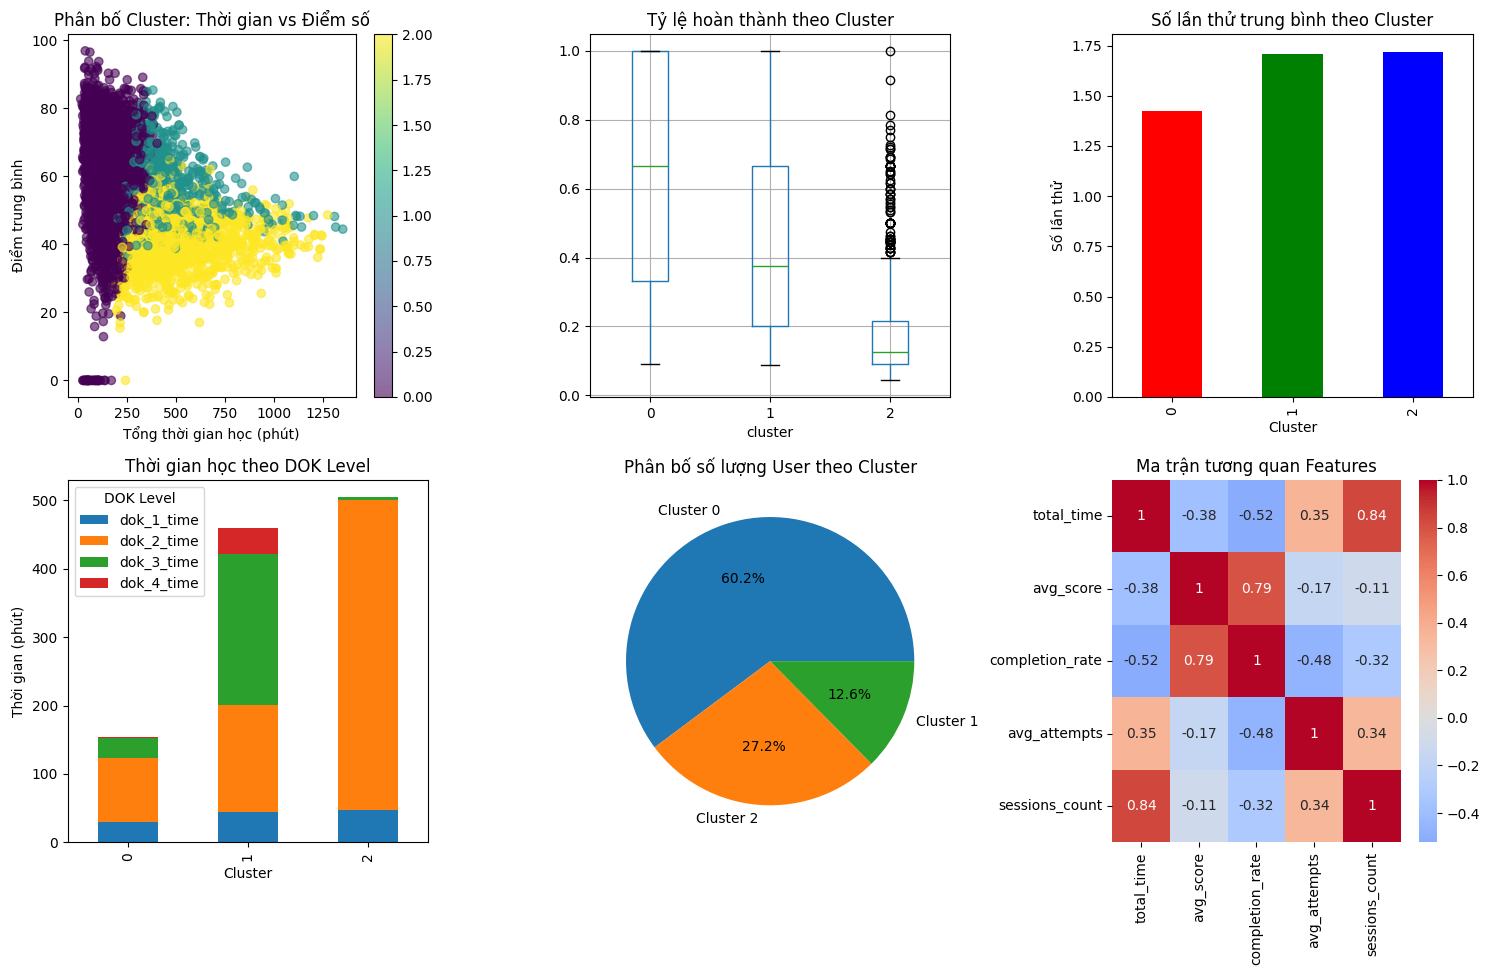

Bắt đầu huấn luyện Q-learning...
Episode 0/500
Episode 100/500
Episode 200/500
Episode 300/500
Episode 400/500
Huấn luyện hoàn tất.
Đã lưu Q-table với 3118 entries vào model/qtable.csv
✅ Đã hoàn thành hết các object học được.

📚 Gợi ý lộ trình học tập cho user 2910.0 (cluster 0.0):
Bước 1: [Next] 1.2.1 (DOK 2, 15 phút, dự đoán điểm: 59.0)
Bước 2: [Previous] 1.1.1 (DOK 1, 10 phút, dự đoán điểm: 62.2)
Bước 3: [Go_to_low_level] 1.1.2 (DOK 2, 15 phút, dự đoán điểm: 59.1)
Bước 4: [Next] 1.1.3 (DOK 3, 10 phút, dự đoán điểm: 59.2)
Bước 5: [Go_to_low_level] 1.2.2 (DOK 2, 20 phút, dự đoán điểm: 57.5)
Bước 6: [Go_to_low_level] 1.2.3 (DOK 3, 25 phút, dự đoán điểm: 54.4)
Bước 7: [Go_to_low_level] 2.1.1 (DOK 1, 12 phút, dự đoán điểm: 61.6)
Bước 8: [Go_to_high_level] 2.1.2 (DOK 2, 20 phút, dự đoán điểm: 57.5)
Bước 9: [Next] 2.1.3 (DOK 3, 15 phút, dự đoán điểm: 57.6)
Bước 10: [Go_to_low_level] 2.2.1 (DOK 2, 20 phút, dự đoán điểm: 57.5)
Bước 11: [Next] 2.2.2 (DOK 3, 15 phút, dự đoán điểm: 57.6)
Bước 1

In [14]:
# 1. Load course structure & generate logs
course_loader = CourseLoader('data/course_structure.json')
log_generator = MoodleLogGenerator(course_loader)
logs_df = log_generator.generate_user_logs(num_users=5000, days_range=30, seed=42)
log_generator.save_logs_to_csv(logs_df, 'data/moodle_logs.csv')

# 2. Chuẩn bị clustering
cluster_service = UserClusteringService()
user_features_df = cluster_service.prepare_features(logs_df)

# 3. Tìm số cụm tối ưu
optimal_k = cluster_service.find_optimal_clusters(user_features_df, k_range=range(2, 6))

# 4. Phân cụm & lưu kết quả
user_clusters_df = cluster_service.cluster_users(user_features_df)
cluster_service.save_clusters_to_csv(user_clusters_df, 'data/user_clusters.csv')

# 5. In kết quả & trực quan hóa
print("✅ Đã phân cụm người học với số cụm tối ưu =", optimal_k)
print(user_clusters_df['cluster'].value_counts())
cluster_service.visualize_clusters(user_clusters_df)

# 6. Huấn luyện Q-learning
ql_system = QLearningRecommendationSystem(course_loader)
ql_system.train(logs_df, user_clusters_df, episodes=500)
ql_system.save_qtable_to_csv()
ql_system.fit_score_predictor(logs_df)

# 7. Gợi ý lộ trình học tập cho một user mẫu
sample_user = user_clusters_df.sample(1).iloc[0]
user_id = sample_user['user_id']
cluster = sample_user['cluster']

# Lấy object đầu tiên mà user đã học
user_logs = logs_df[logs_df['user_id'] == user_id].sort_values('timestamp')

if not user_logs.empty:
    first_log = user_logs.iloc[0]
    current_object = first_log['object_id']
    score = first_log['score']
    attempts = first_log['attempts']
    time_spent = first_log['time_spent']

    # Sinh gợi ý lộ trình
    recommendations = ql_system.recommend_learning_path(
        user_id=user_id,
        cluster=cluster,
        current_object=current_object,
        score=score,
        attempts=attempts,
        time_spent=time_spent,
        path_length=10000
    )

    # In kết quả gợi ý
    print(f"\n📚 Gợi ý lộ trình học tập cho user {user_id} (cluster {cluster}):")
    for rec in recommendations:
        print(f"Bước {rec['step']}: [{rec['action']}] {rec['object_name']} "
              f"(DOK {rec['dok_level']}, {rec['estimated_time']} phút, "
              f"dự đoán điểm: {rec['predicted_score']})")
else:
    print("⚠️ Không tìm thấy log cho user mẫu.")